## 1. Data Importing

This section addresses the following question:

_(1) Is the distribution of actors born under each zodiac sign even? Which zodiac sign has the highest representation among actors?_

First, we should **import the dataset**.


In [1]:
import pandas as pd

def getCharacterMeta(filepath):
    CharacterMeta = pd.read_csv(filepath, sep='\t')
    
    CharacterMeta.columns = [
        'Wikipedia movie ID',
        'Freebase movie ID',
        'Movie release date',
        'Character name',
        'Actor date of birth',
        'Actor gender',
        'Actor height',
        'Actor ethnicity',
        'Actor name',
        'Actor age at movie release',
        'Freebase character/actor map ID',
        'Freebase character ID',
        'Freebase actor ID'
    ]
    return CharacterMeta

# Load Data
file_path = "../data/RawDatasets/MovieSummaries/character.metadata.tsv"
CharacterMeta = getCharacterMeta(file_path)


In [2]:
total_records = len(CharacterMeta)
print(f"Total records: {total_records}")


Total records: 330572



## 2, Data Revealing

To get as much as **valid data** as we can, I want to check the data format, and transform some of them if possible.
Now, I will explore the data format for the 'Actor date of birth' column.

In [3]:
df_dates = CharacterMeta['Actor date of birth'].fillna("").copy()
df_dates = "'" + df_dates + "'"

# Get value_counts from dataset, and reset index
date_formats = df_dates.value_counts(dropna=False).reset_index()
date_formats.columns = ['Presentation', 'Count']
date_formats['Length'] = date_formats['Presentation'].apply(len)-2  # Account for quotes

date_formats = date_formats.sort_values(by='Length')

combined_formats = pd.concat([date_formats.head(), date_formats.tail(5)])
print("Date Formats in Actor date of birth:\n", combined_formats)

Date Formats in Actor date of birth:
                       Presentation  Count  Length
0                               ''  77671       0
22                          '1953'    164       4
23                          '1958'    162       4
25                          '1941'    156       4
28                          '1968'    155       4
9506                  '1971-10-06'      8      10
9505                  '1969-10-03'      8      10
9504                  '1901-09-12'      8      10
13269     '1961-08-04T19:24-10:00'      5      22
11184  '1930-01-01T00:00:00-04:00'      6      25


In [4]:
import re


def classify_date_format(date_str):
    if pd.isna(date_str) or date_str.strip() == '':
        return 'Empty'
    elif re.match(r'^\d{4}$', date_str):  # Matches year only format (e.g., '1953')
        return 'Year only'
    elif re.match(r'^\d{4}-\d{2}$', date_str):  # Matches year-month format (e.g., '1938-01')
        return 'Year-Month'
    elif re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):  # Matches full date (e.g., '1971-10-06')
        return 'Full date (YYYY-MM-DD)'
    elif re.match(r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}(:\d{2})?([+-]\d{2}:\d{2})?$', date_str):
        # Matches datetime with optional seconds and timezone (e.g., '1961-08-04T19:24-10:00')
        return 'Datetime with timezone'
    else:
        return 'Other'

CharacterMeta['Date Format Type'] = CharacterMeta['Actor date of birth'].fillna("").apply(classify_date_format)
date_format_counts = CharacterMeta['Date Format Type'].value_counts(dropna=False).reset_index()
date_format_counts.columns = ['Date Format Type', 'Count']

print(date_format_counts)




         Date Format Type   Count
0  Full date (YYYY-MM-DD)  242099
1                   Empty   77671
2               Year only   10248
3              Year-Month     543
4  Datetime with timezone      11


In [5]:
# Filter to show only rows where the Date Format Type is 'Other'
# These code were run several times to gradually clean out the 'other' format than full date format.
other_formats = CharacterMeta[CharacterMeta['Date Format Type'] == 'Other']

other_format_counts = other_formats['Actor date of birth'].value_counts().reset_index()
other_format_counts.columns = ['Actor date of birth', 'Count']

if other_format_counts.empty:
    print('Completed: types of data representation are all detected.')
else:
    print(other_format_counts)


Completed: types of data representation are all detected.


## 3, Data Cleaning

After sorting out all the datatypes, we can start cleaning dataset.

In [6]:
CharacterMeta_cleaned = CharacterMeta.copy()

# Filter out rows with "Empty", "Year only", and "Year-Month" in the 'Date Format Type' column
CharacterMeta_cleaned = CharacterMeta_cleaned[
    ~CharacterMeta_cleaned['Date Format Type'].isin(['Empty', 'Year only', 'Year-Month'])
]


def convert_to_date_only(date_str):
    if 'T' in date_str:
        return date_str[:10]  # Extract only the 'YYYY-MM-DD' part
    return date_str
    
CharacterMeta_cleaned['Actor date of birth'] = CharacterMeta_cleaned['Actor date of birth'].apply(convert_to_date_only)


# Verify
CharacterMeta_cleaned['Date Format Type'] = CharacterMeta_cleaned['Actor date of birth'].fillna("").apply(classify_date_format)
date_format_counts = CharacterMeta_cleaned['Date Format Type'].value_counts(dropna=False).reset_index()
date_format_counts.columns = ['Date Format Type', 'Count']
print(date_format_counts)

# Check again
missing_birthdates = CharacterMeta_cleaned['Actor date of birth'].isna().sum()
print(f"Number of missing or invalid birthdates: {missing_birthdates}")


         Date Format Type   Count
0  Full date (YYYY-MM-DD)  242110
Number of missing or invalid birthdates: 0


### Keep searching for invalid data
Now, all the data are in the form of YYYY-MM-DD. However, we can't simply trust the data recorders just like that. What if a 0000-00-00 exsits?
After searching, we find a useful library called datetime, which can automatically convert invalid data to none.

In [7]:
# Create a backup of the original 'Actor date of birth' column
CharacterMeta_cleaned['Original Actor date of birth'] = CharacterMeta_cleaned['Actor date of birth']

# Attempt to convert 'Actor date of birth' to datetime, marking invalid ones as NaT
CharacterMeta_cleaned['Converted Date'] = pd.to_datetime(CharacterMeta_cleaned['Actor date of birth'], errors='coerce')

invalid_dates = CharacterMeta_cleaned[CharacterMeta_cleaned['Converted Date'].isna()]

print("Invalid dates before cleaning:")
print(invalid_dates[['Original Actor date of birth']])

Invalid dates before cleaning:
       Original Actor date of birth
39426                    0019-11-28
42282                    0019-10-30
45079                    0019-03-22
80338                    0019-11-28
92870                    1075-08-19
107165                   0852-03-10
137375                   0195-02-07
163427                   0019-02-22
172159                   1075-08-19
246641                   0019-11-26
290659                   0019-11-28
300064                   2896-04-26
322332                   9900-09-07
325420                   0019-11-28


This dataset is really not trustworthy. Anyway, after cleaned these data out, the data are finally cleaned. though, the accuracy is still a question, but we decided not to delve in it too much, avoiding making the whole project becoming meaningless.

In [8]:
# Drop rows where 'Converted Date' is NaT
CharacterMeta_cleaned = CharacterMeta_cleaned.dropna(subset=['Converted Date'])

# Replace the old 'Actor date of birth' with 'Converted Date' and drop 'Original Actor date of birth'
CharacterMeta_cleaned['Actor date of birth'] = CharacterMeta_cleaned['Converted Date']
CharacterMeta_cleaned = CharacterMeta_cleaned.drop(columns=['Original Actor date of birth', 'Converted Date', 'Date Format Type'])


In [9]:
print(CharacterMeta_cleaned.head())
print(f"\nNumber of remaining rows: {len(CharacterMeta_cleaned)}")

   Wikipedia movie ID Freebase movie ID Movie release date  \
0              975900         /m/03vyhn         2001-08-24   
1              975900         /m/03vyhn         2001-08-24   
2              975900         /m/03vyhn         2001-08-24   
3              975900         /m/03vyhn         2001-08-24   
4              975900         /m/03vyhn         2001-08-24   

               Character name Actor date of birth Actor gender  Actor height  \
0  Lieutenant Melanie Ballard          1974-08-15            F         1.780   
1         Desolation Williams          1969-06-15            M         1.727   
2          Sgt Jericho Butler          1967-09-12            M         1.750   
3             Bashira Kincaid          1977-09-25            F         1.650   
4   Commander Helena Braddock          1949-05-26            F         1.727   

  Actor ethnicity          Actor name  Actor age at movie release  \
0      /m/044038p  Natasha Henstridge                        27.0   
1       

### Data Cleaning Summary

The dataset underwent the following cleaning steps to ensure consistent date formats in the `'Actor date of birth'` column:

1. **Initial Data Exploration**:
   - The dataset initially included several formats in the `'Actor date of birth'` column, such as:
     - Full date format (`YYYY-MM-DD`)
     - Year-only (`YYYY`)
     - Year-Month (`YYYY-MM`)
     - Datetime with timezone (`YYYY-MM-DDTHH:MM:SS±HH:MM`)

2. **Removal of Non-Standard Date Entries**:
   - Rows where `'Actor date of birth'` was empty or in partial formats like `Year-only` and `Year-Month` were filtered out, as they didn’t meet the criteria for accurate zodiac determination.

3. **Date Format Conversion**:
   - Entries in the `Datetime with timezone` format were converted to the `Full date` format (`YYYY-MM-DD`) by extracting only the date portion.
   - A total of 14 dates remained invalid after the initial parsing; these were rechecked, and rows containing them were subsequently removed.

4. **Final Column Adjustments**:
   - The converted date information replaced the original `'Actor date of birth'` column.
   - Columns used during the transformation, such as `'Original Actor date of birth'` and `'Converted Date'`, were dropped to streamline the dataset.

### Result:
- The cleaned dataset now contains **242,096 rows**, with all entries in the `'Actor date of birth'` column in the `YYYY-MM-DD` format, allowing for accurate date-related analysis, including zodiac sign determination.

This ensures consistent and complete data for further exploration and analysis.





## 4, Define Zodiac Sign Function
Now the data is cleaned. These data will be used to represent the zodiac. It's time to define the zodiac sign function.

In [10]:
# Zodiac sign function provided by user (modified to clarify the Capricorn range)
def get_zodiac_sign(birthdate):
    if pd.isna(birthdate):  # Check for NaT
        return None
    month_day = birthdate.strftime("%m-%d")  # Extract 'MM-DD' as a string
    if "03-21" <= month_day <= "04-19":
        return "Aries"
    elif "04-20" <= month_day <= "05-20":
        return "Taurus"
    elif "05-21" <= month_day <= "06-20":
        return "Gemini"
    elif "06-21" <= month_day <= "07-22":
        return "Cancer"
    elif "07-23" <= month_day <= "08-22":
        return "Leo"
    elif "08-23" <= month_day <= "09-22":
        return "Virgo"
    elif "09-23" <= month_day <= "10-22":
        return "Libra"
    elif "10-23" <= month_day <= "11-21":
        return "Scorpio"
    elif "11-22" <= month_day <= "12-21":
        return "Sagittarius"
    elif "12-22" <= month_day <= "12-31" or "01-01" <= month_day <= "01-19":
        return "Capricorn"
    elif "01-20" <= month_day <= "02-18":
        return "Aquarius"
    elif "02-19" <= month_day <= "03-20":
        return "Pisces"
    return None



CharacterMeta_cleaned['Zodiac Sign'] = CharacterMeta_cleaned['Actor date of birth'].apply(get_zodiac_sign)

# count the occurrences of each zodiac
zodiac_counts = CharacterMeta_cleaned['Zodiac Sign'].value_counts(dropna=False).reset_index()
zodiac_counts.columns = ['Zodiac Sign', 'Count']

zodiac_counts = zodiac_counts.sort_values(by="Count", ascending=False)
print(zodiac_counts)


    Zodiac Sign  Count
0        Gemini  21758
1           Leo  21125
2         Libra  21061
3         Virgo  20847
4        Cancer  20577
5         Aries  20277
6        Pisces  20017
7      Aquarius  20001
8       Scorpio  19520
9   Sagittarius  19160
10       Taurus  19100
11    Capricorn  18653


### Illustration


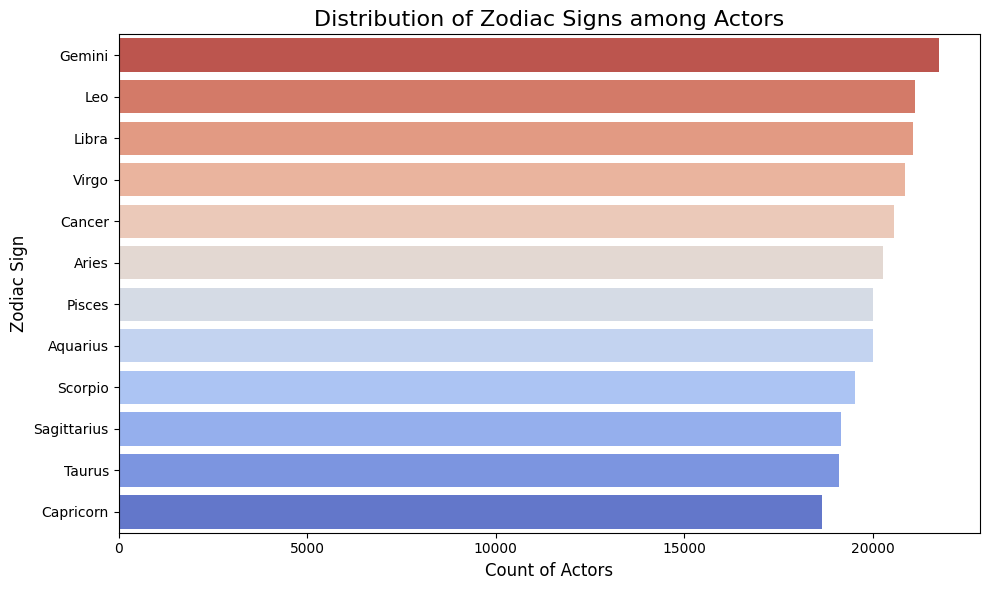

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create a bar plot with a color map
sns.barplot(x='Count', y='Zodiac Sign', data=zodiac_counts, palette='coolwarm_r',hue='Zodiac Sign',legend=False)

# Add labels and title
plt.title('Distribution of Zodiac Signs among Actors', fontsize=16)
plt.xlabel('Count of Actors', fontsize=12)
plt.ylabel('Zodiac Sign', fontsize=12)

plt.tight_layout()
plt.show()




## 5, Significant?
We used Z-test and Chi-square test to test whether the differences in the zodiac sign distribution are significant.

### (1) Z-Test
Compare observed proportion for **each zodiac sign** to the overall mean proportion.

In [13]:
from scipy.stats import norm

# Compute the observed proportions
total_count = zodiac_counts['Count'].sum()
zodiac_counts['Proportion'] = zodiac_counts['Count'] / total_count

# Compute the overall mean proportion
mean_proportion = 1 / len(zodiac_counts['Zodiac Sign'].dropna())
std_proportion = np.sqrt(mean_proportion * (1 - mean_proportion) / total_count)

# Calculate z-scores and p-values
zodiac_counts['Z-Score'] = (zodiac_counts['Proportion'] - mean_proportion) / std_proportion
zodiac_counts['P-Value'] = 2 * (1 - norm.cdf(abs(zodiac_counts['Z-Score'])))

# Check significance level = 0.05
zodiac_counts['Significant?'] = zodiac_counts['P-Value'] < 0.05

print(zodiac_counts[['Zodiac Sign', 'Proportion', 'Z-Score', 'P-Value', 'Significant?']])


    Zodiac Sign  Proportion    Z-Score       P-Value  Significant?
0        Gemini    0.089873  11.642961  0.000000e+00          True
1           Leo    0.087259   6.988228  2.783773e-12          True
2         Libra    0.086994   6.517607  7.143774e-11          True
3         Virgo    0.086110   4.943969  7.654788e-07          True
4        Cancer    0.084995   2.958538  3.091024e-03          True
5         Aries    0.083756   0.752503  4.517486e-01         False
6        Pisces    0.082682  -1.159394  2.462957e-01         False
7      Aquarius    0.082616  -1.277049  2.015849e-01         False
8       Scorpio    0.080629  -4.814058  1.478958e-06          True
9   Sagittarius    0.079142  -7.461300  8.570922e-14          True
10       Taurus    0.078894  -7.902507  2.664535e-15          True
11    Capricorn    0.077048 -11.189499  0.000000e+00          True


### Z-Scores Observations
- Significant deviations: Signs like **Gemini**, **Leo**, **Libra**, **Virgo**, **Scorpio**, **Sagittarius**, **Taurus**, and **Capricorn** show statistically significant differences (*p-value* < 0.05).  
- No significant difference: Signs like **Aries**, **Pisces**, and **Aquarius** have proportions that are not significantly different from the expected uniform distribution (*p-value* > 0.05).  

This means that these three signs are more evenly represented relative to the expected proportion, whereas the others are either overrepresented or underrepresented significantly.


### (2) Chi-square test
Compare the observed zodiac distribution to an expected uniform distribution.

In [14]:
from scipy.stats import chisquare

# Expected uniform distribution
expected_counts = [total_count / len(zodiac_counts['Zodiac Sign'].dropna())] * len(zodiac_counts['Zodiac Sign'].dropna())

# Observed counts
observed_counts = zodiac_counts['Count'].dropna()

chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")

# Check significance level
if p_value < 0.05:
    print("Reject H0: The zodiac distribution is significantly different from uniform.")
else:
    print("Fail to reject H0: The zodiac distribution is not significantly different from uniform.")


Chi-Square Statistic: 485.9349018571145
P-Value: 3.1972114794589453e-97
Reject H0: The zodiac distribution is significantly different from uniform.


# Note for groupmate

As we added a 'Zodiac sign' column, use the newest _getCharacterMeta_ function

In [15]:
# print(CharacterMeta_cleaned)

In [16]:
import os

output_directory = '../data/ProcessedDatasets/'
output_filename = 'cleaned.character.metadata.tsv'
output_path = os.path.join(output_directory, output_filename)

# Ensure the directory exists
os.makedirs(output_directory, exist_ok=True)

# Check if the file already exists
if not os.path.exists(output_path):
    CharacterMeta_cleaned.to_csv(output_path, sep='\t', index=False)
    print(f"Dataset successfully exported to: {output_path}")
else:
    print(f"File already exists: {output_path}. Export skipped.")


File already exists: ../data/ProcessedDatasets/cleaned.character.metadata.tsv. Export skipped.


In [17]:
file_path = "../data/ProcessedDatasets/cleaned.character.metadata.tsv"
def getCharacterMeta(filepath):
    CharacterMeta = pd.read_csv(filepath, sep='\t')
    
    CharacterMeta.columns = [
        'Wikipedia movie ID',
        'Freebase movie ID',
        'Movie release date',
        'Character name',
        'Actor date of birth',
        'Actor gender',
        'Actor height',
        'Actor ethnicity',
        'Actor name',
        'Actor age at movie release',
        'Freebase character/actor map ID',
        'Freebase character ID',
        'Freebase actor ID',
        'Zodiac sign'
    ]
    return CharacterMeta


In [18]:
CharacterMeta = getCharacterMeta(file_path)
total_records = len(CharacterMeta)
print(f"Total records: {total_records}")

Total records: 242096
